In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score ,f1_score, ConfusionMatrixDisplay, classification_report

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim
from tqdm import tqdm, trange
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudn
import torchvision
from torchvision import datasets, models, transforms

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor/P_343.jpg
/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor/M_187.jpg
/kaggle/input/brain-tumors-256x256/Data/glioma_tumor/G_622.jpg
/kaggle/input/brain-tumors-256x256/Data/normal/N_125.jpg


In [2]:
glioma_tumor="/kaggle/input/brain-tumors-256x256/Data/glioma_tumor"
glioma_files = os.listdir(glioma_tumor) #return a list including the name of file in directory

meningioma_tumor="/kaggle/input/brain-tumors-256x256/Data/meningioma_tumor"
meningioma_files = os.listdir(meningioma_tumor)

normal="/kaggle/input/brain-tumors-256x256/Data/normal"
normal_files = os.listdir(normal)


pituitary_tumor="/kaggle/input/brain-tumors-256x256/Data/pituitary_tumor"
pituitary_files= os.listdir(pituitary_tumor)


# ****The number of images in each class****

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector)

Text(0.5, 1.0, 'Number of images per class')

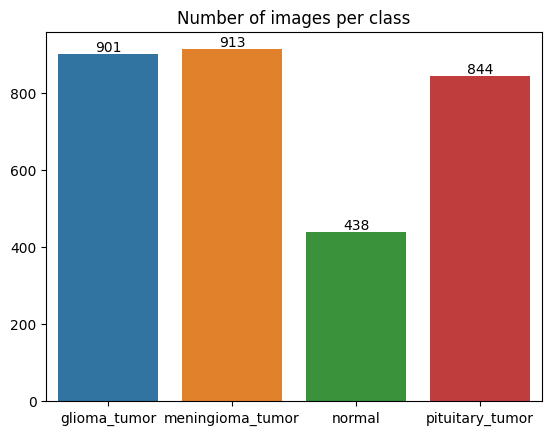

In [3]:
labels_name = ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']
image_per_class = [len(x) for x in  (glioma_files, meningioma_files, normal_files, pituitary_files)]

ax = sns.barplot(x=labels_name, y=image_per_class, errwidth=0)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of images per class')

# **Analyzing Image Properties**

** To gain deeper insights into our image data, we can extract size, resolution, and colour distribution from the images within the subdirectories**

In [4]:
sizes = []
resolutions = []
color_distributions = []
images = []
image_shapes = []  

root_path = "/kaggle/input/brain-tumors-256x256/Data/"

# Iterate over each image file in each subdirectory
for dirpath, dirnames, filenames in os.walk(root_path):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load the image file using OpenCV
            img_path = os.path.join(dirpath, filename)
            img = cv2.imread(img_path)
            
            image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            images.append(image)
    
            # Obtain shape of each image and store them in an array
            (width, height) = image.shape[1], image.shape[0]
            image_shapes.append((width, height))



            # Extract the size of the image
            size = os.path.getsize(img_path)
            sizes.append(size)

            # Extract the resolution of the image
            resolution = img.shape[:2]
            resolutions.append(resolution)

            # Extract the color distribution of the image
            color_distribution = np.bincount(img.flatten(), minlength=256)
            color_distributions.append(color_distribution)

# Convert the lists to numpy arrays for easier manipulation
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

# Return only unique shapes
unique_shapes = list(set(image_shapes))

Text(313.26767676767673, 0.5, 'Height (pixels)')

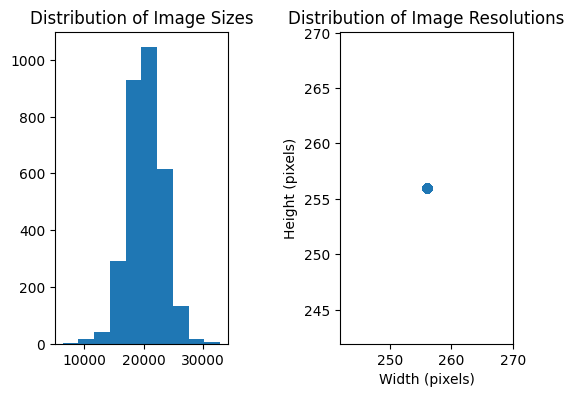

In [5]:
fig, (ax1,ax2) = plt.subplots(1, 2) 
fig.tight_layout(pad=5.0)

ax1.hist(sizes)
ax1.set_title("Distribution of Image Sizes")


ax2.scatter(resolutions[:, 0], resolutions[:, 1])
ax2.set_title("Distribution of Image Resolutions")
ax2.set_xlabel("Width (pixels)")
ax2.set_ylabel("Height (pixels)")

In [6]:
data_path=[]
for dirpath, dirnames, filenames in os.walk(root_path):
    data_path.append(dirpath)
    
data = []

for class_path in data_path[1:]:
    class_name = class_path.split("/")[-1]
    print(class_name)
    for img_path in [os.path.join(class_path +"/" +file ) for file in os.listdir(class_path)]:
        data.append([img_path, class_name])


pituitary_tumor
meningioma_tumor
glioma_tumor
normal


In [7]:
# train set and test set division
from random import shuffle
shuffle(data)
train_len = int(0.7*len(data))
train_set = data[0:train_len]
test_set = data[train_len:]
print(train_len)
print(len(train_set))
print(len(test_set))



2167
2167
929


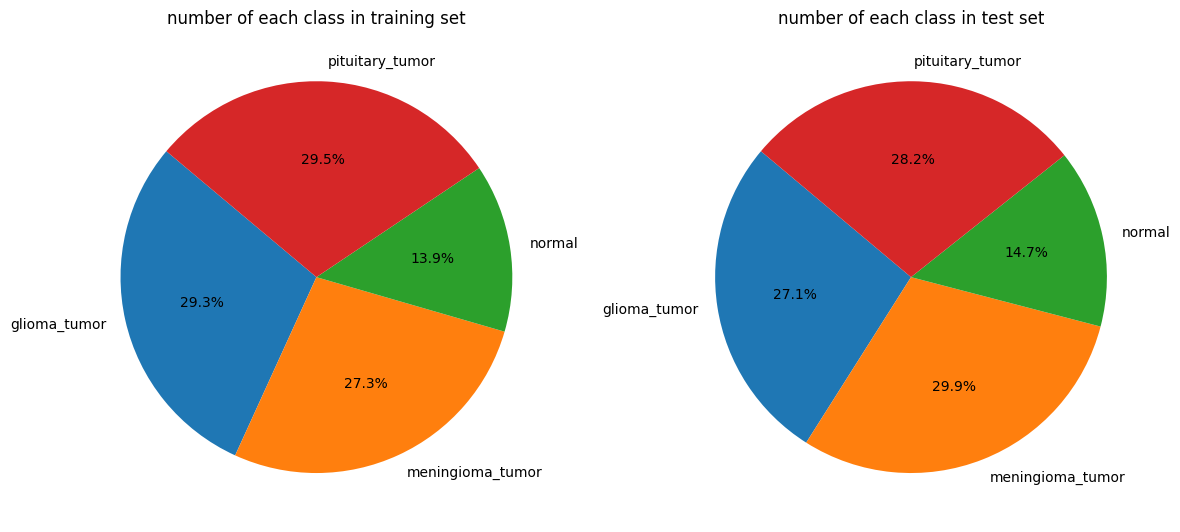

In [8]:
classes_train = [classes[1] for classes in train_set]
classes_test = [classes[1] for classes in test_set]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.pie(list(Counter(classes_train).values()), labels=labels_name, autopct='%1.1f%%', startangle=140)
ax1.set_title('number of each class in training set')

# Plotting the second pie chart
ax2.pie(list(Counter(classes_test).values()), labels=labels_name, autopct='%1.1f%%', startangle=140)
ax2.set_title('number of each class in test set')

# Set the same color cycle for both pie charts
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax1.set_prop_cycle('color', colors)
ax2.set_prop_cycle('color', colors)

plt.tight_layout()
plt.show()

In [9]:
label_map = {'pituitary_tumor' : 0, 'meningioma_tumor' : 1, 'glioma_tumor': 2, 'normal' : 3}

# **Pre-Processing**

****normalizing and resizing data****

In [10]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [11]:
class CustomDataset(Dataset):
    def __init__(self, data, label_map, transform):
        self.data = data
        self.transform = transform
        self.labels = label_map

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image_path, class_name = self.data[idx]
        img = Image.open(image_path).convert('RGB')
        class_id = self.labels[class_name]
        class_id = torch.tensor(class_id)
        return self.transform(img), class_id

In [12]:
train_data = CustomDataset(train_set, label_map, data_transforms['train'])
test_data = CustomDataset(test_set, label_map, data_transforms['test'])

train_loader = DataLoader(train_data,
                          batch_size= 32, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data,
                         batch_size= 32, shuffle= False, pin_memory= True)

# ****Define ResNet-18 architecture****

In [13]:
# Option 1: Defining ResNet-18 architecture
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1,  identity_downsample=None):
        super(BasicBlock, self).__init__()
        self.identity_downsample = identity_downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        


    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        out += identity
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, img_channels, num_layers, num_classes, block):
        super(ResNet, self).__init__()
        if num_layers == 18:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
            
        self.in_channels = 64
        self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels=self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1, identity_downsample=None):
        if stride != 1:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, identity_downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


# Define Train and evaluation functions

In [14]:
#training function
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
        
    for step ,batch in enumerate (trainloader):

        counter += 1
        image, labels = batch
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [15]:
# Validation function.
def evaluate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for step ,batch in enumerate (testloader):

            counter += 1
            
            image, labels = batch
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

> **defining hyperparameter and everything we need for training**

In [16]:
epochs = 20
batch_size = 32
learning_rate = 0.01
num_classes = 4
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = ResNet(img_channels=3, num_layers=18, block=BasicBlock, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)


In [17]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

11178564

In [18]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
for _ in trange(epochs, desc='Epoch'):
    train_epoch_loss, train_epoch_acc = train(
        model, 
        train_loader, 
        optimizer, 
        criterion,
        device
    )
    valid_epoch_loss, valid_epoch_acc = evaluate(
        model, 
        test_loader, 
        criterion,
        device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training
Validation


Epoch:   5%|▌         | 1/20 [00:12<03:51, 12.20s/it]

Training loss: 1.206, training acc: 47.716
Validation loss: 1.046, validation acc: 63.079
--------------------------------------------------
Training
Validation


Epoch:  10%|█         | 2/20 [00:23<03:25, 11.43s/it]

Training loss: 1.006, training acc: 57.037
Validation loss: 1.306, validation acc: 45.533
--------------------------------------------------
Training
Validation


Epoch:  15%|█▌        | 3/20 [00:34<03:13, 11.37s/it]

Training loss: 0.883, training acc: 62.898
Validation loss: 1.146, validation acc: 57.589
--------------------------------------------------
Training
Validation


Epoch:  20%|██        | 4/20 [00:45<02:57, 11.12s/it]

Training loss: 0.850, training acc: 64.329
Validation loss: 0.824, validation acc: 63.832
--------------------------------------------------
Training
Validation


Epoch:  25%|██▌       | 5/20 [00:56<02:46, 11.10s/it]

Training loss: 0.786, training acc: 68.297
Validation loss: 0.874, validation acc: 62.756
--------------------------------------------------
Training
Validation


Epoch:  30%|███       | 6/20 [01:07<02:35, 11.11s/it]

Training loss: 0.718, training acc: 70.974
Validation loss: 0.611, validation acc: 78.471
--------------------------------------------------
Training
Validation


Epoch:  35%|███▌      | 7/20 [01:18<02:23, 11.02s/it]

Training loss: 0.705, training acc: 71.066
Validation loss: 0.899, validation acc: 61.141
--------------------------------------------------
Training
Validation


Epoch:  40%|████      | 8/20 [01:29<02:13, 11.14s/it]

Training loss: 0.673, training acc: 74.066
Validation loss: 0.721, validation acc: 74.489
--------------------------------------------------
Training
Validation


Epoch:  45%|████▌     | 9/20 [01:41<02:04, 11.31s/it]

Training loss: 0.649, training acc: 73.973
Validation loss: 0.434, validation acc: 85.361
--------------------------------------------------
Training
Validation


Epoch:  50%|█████     | 10/20 [01:52<01:52, 11.21s/it]

Training loss: 0.606, training acc: 75.819
Validation loss: 0.612, validation acc: 75.673
--------------------------------------------------
Training
Validation


Epoch:  55%|█████▌    | 11/20 [02:03<01:40, 11.21s/it]

Training loss: 0.601, training acc: 76.050
Validation loss: 0.416, validation acc: 84.607
--------------------------------------------------
Training
Validation


Epoch:  60%|██████    | 12/20 [02:14<01:28, 11.12s/it]

Training loss: 0.553, training acc: 78.034
Validation loss: 0.502, validation acc: 78.256
--------------------------------------------------
Training
Validation


Epoch:  65%|██████▌   | 13/20 [02:25<01:17, 11.02s/it]

Training loss: 0.571, training acc: 78.126
Validation loss: 0.581, validation acc: 77.503
--------------------------------------------------
Training
Validation


Epoch:  70%|███████   | 14/20 [02:36<01:07, 11.18s/it]

Training loss: 0.523, training acc: 78.496
Validation loss: 0.681, validation acc: 74.273
--------------------------------------------------
Training
Validation


Epoch:  75%|███████▌  | 15/20 [02:47<00:55, 11.02s/it]

Training loss: 0.520, training acc: 79.557
Validation loss: 0.337, validation acc: 87.836
--------------------------------------------------
Training
Validation


Epoch:  80%|████████  | 16/20 [02:58<00:43, 10.95s/it]

Training loss: 0.501, training acc: 80.249
Validation loss: 0.357, validation acc: 87.083
--------------------------------------------------
Training
Validation


Epoch:  85%|████████▌ | 17/20 [03:09<00:32, 11.00s/it]

Training loss: 0.465, training acc: 82.510
Validation loss: 0.568, validation acc: 79.333
--------------------------------------------------
Training
Validation


Epoch:  90%|█████████ | 18/20 [03:20<00:21, 11.00s/it]

Training loss: 0.494, training acc: 81.218
Validation loss: 0.471, validation acc: 82.454
--------------------------------------------------
Training
Validation


Epoch:  95%|█████████▌| 19/20 [03:31<00:10, 10.99s/it]

Training loss: 0.488, training acc: 81.772
Validation loss: 0.770, validation acc: 72.443
--------------------------------------------------
Training
Validation


Epoch: 100%|██████████| 20/20 [03:43<00:00, 11.18s/it]

Training loss: 0.465, training acc: 82.049
Validation loss: 0.587, validation acc: 76.857
--------------------------------------------------


# Visualize performance of training resnet model. from scratch

Text(0.5, 1.0, 'test acc')

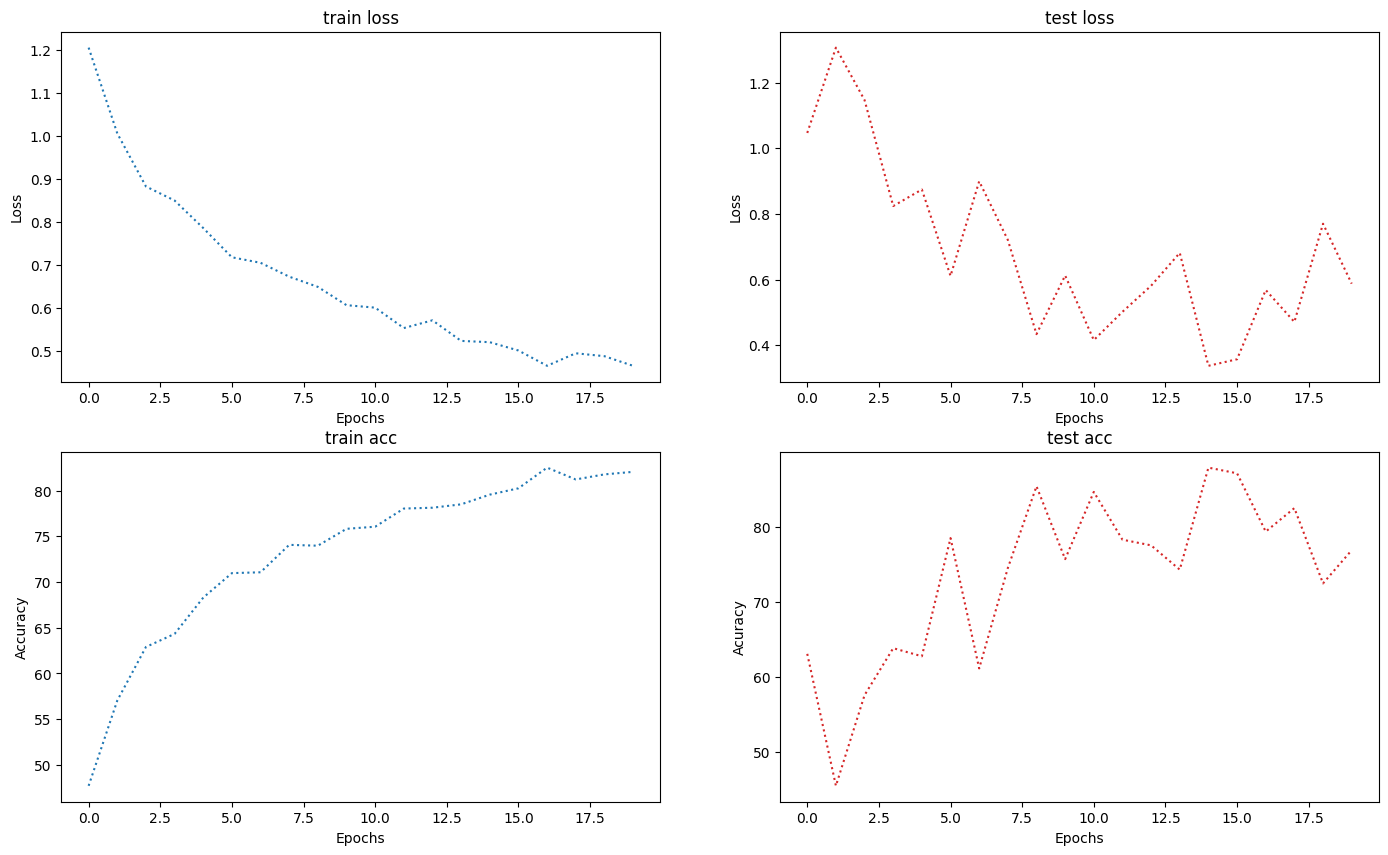

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))

axs[0,0].plot(train_loss, color='tab:blue', linestyle='dotted')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('train loss')

axs[0,1].plot(valid_loss, color='tab:red', linestyle='dotted')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('test loss')

axs[1,0].plot(train_acc, color='tab:blue', linestyle='dotted')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('train acc')

axs[1,1].plot(valid_acc, color='tab:red', linestyle='dotted')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Acuracy')
axs[1,1].set_title('test acc')

# FineTuning ResNet-18

>   **Load Pre-trained ResNet-18 Model and modify last layer weights**

In [20]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


In [21]:
train_loss_ft, valid_loss_ft = [], []
train_acc_ft, valid_acc_ft = [], []
for _ in trange(epochs, desc='Epoch'):
    train_epoch_loss_ft, train_epoch_acc_ft = train(
        model_ft, 
        train_loader, 
        optimizer_ft, 
        criterion,
        device
    )
    valid_epoch_loss_ft, valid_epoch_acc_ft = evaluate(
        model_ft, 
        test_loader, 
        criterion,
        device
    )
    train_loss_ft.append(train_epoch_loss_ft)
    valid_loss_ft.append(valid_epoch_loss_ft)
    train_acc_ft.append(train_epoch_acc_ft)
    valid_acc_ft.append(valid_epoch_acc_ft)
    print(f"Training loss_ft: {train_epoch_loss_ft:.3f}, training acc_ft: {train_epoch_acc_ft:.3f}")
    print(f"Validation loss_ft: {valid_epoch_loss_ft:.3f}, validation acc_ft: {valid_epoch_acc_ft:.3f}")
    print('-'*50)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training
Validation


Epoch:   5%|▌         | 1/20 [00:11<03:29, 11.04s/it]

Training loss_ft: 0.739, training acc_ft: 71.066
Validation loss_ft: 0.327, validation acc_ft: 88.590
--------------------------------------------------
Training
Validation


Epoch:  10%|█         | 2/20 [00:22<03:26, 11.45s/it]

Training loss_ft: 0.415, training acc_ft: 84.126
Validation loss_ft: 0.260, validation acc_ft: 91.389
--------------------------------------------------
Training
Validation


Epoch:  15%|█▌        | 3/20 [00:36<03:31, 12.44s/it]

Training loss_ft: 0.350, training acc_ft: 86.433
Validation loss_ft: 0.268, validation acc_ft: 90.312
--------------------------------------------------
Training
Validation


Epoch:  20%|██        | 4/20 [00:47<03:09, 11.87s/it]

Training loss_ft: 0.312, training acc_ft: 88.602
Validation loss_ft: 0.346, validation acc_ft: 87.298
--------------------------------------------------
Training
Validation


Epoch:  25%|██▌       | 5/20 [00:59<02:56, 11.79s/it]

Training loss_ft: 0.269, training acc_ft: 89.479
Validation loss_ft: 0.182, validation acc_ft: 93.219
--------------------------------------------------
Training
Validation


Epoch:  30%|███       | 6/20 [01:12<02:50, 12.20s/it]

Training loss_ft: 0.236, training acc_ft: 90.494
Validation loss_ft: 0.171, validation acc_ft: 94.403
--------------------------------------------------
Training
Validation


Epoch:  35%|███▌      | 7/20 [01:23<02:34, 11.87s/it]

Training loss_ft: 0.222, training acc_ft: 91.786
Validation loss_ft: 0.160, validation acc_ft: 94.187
--------------------------------------------------
Training
Validation


Epoch:  40%|████      | 8/20 [01:34<02:19, 11.63s/it]

Training loss_ft: 0.205, training acc_ft: 92.524
Validation loss_ft: 0.189, validation acc_ft: 93.757
--------------------------------------------------
Training
Validation


Epoch:  45%|████▌     | 9/20 [01:45<02:05, 11.43s/it]

Training loss_ft: 0.209, training acc_ft: 91.924
Validation loss_ft: 0.360, validation acc_ft: 87.836
--------------------------------------------------
Training
Validation


Epoch:  50%|█████     | 10/20 [01:56<01:53, 11.30s/it]

Training loss_ft: 0.168, training acc_ft: 94.324
Validation loss_ft: 0.210, validation acc_ft: 92.896
--------------------------------------------------
Training
Validation


Epoch:  55%|█████▌    | 11/20 [02:07<01:41, 11.24s/it]

Training loss_ft: 0.170, training acc_ft: 93.632
Validation loss_ft: 0.149, validation acc_ft: 95.264
--------------------------------------------------
Training
Validation


Epoch:  60%|██████    | 12/20 [02:18<01:29, 11.18s/it]

Training loss_ft: 0.189, training acc_ft: 93.170
Validation loss_ft: 0.209, validation acc_ft: 92.896
--------------------------------------------------
Training
Validation


Epoch:  65%|██████▌   | 13/20 [02:29<01:18, 11.24s/it]

Training loss_ft: 0.162, training acc_ft: 93.955
Validation loss_ft: 0.151, validation acc_ft: 94.833
--------------------------------------------------
Training
Validation


Epoch:  70%|███████   | 14/20 [02:40<01:06, 11.17s/it]

Training loss_ft: 0.143, training acc_ft: 94.647
Validation loss_ft: 0.260, validation acc_ft: 92.357
--------------------------------------------------
Training
Validation


Epoch:  75%|███████▌  | 15/20 [02:51<00:55, 11.15s/it]

Training loss_ft: 0.145, training acc_ft: 94.878
Validation loss_ft: 0.200, validation acc_ft: 93.541
--------------------------------------------------
Training
Validation


Epoch:  80%|████████  | 16/20 [03:03<00:44, 11.11s/it]

Training loss_ft: 0.144, training acc_ft: 94.416
Validation loss_ft: 0.156, validation acc_ft: 95.264
--------------------------------------------------
Training
Validation


Epoch:  85%|████████▌ | 17/20 [03:13<00:33, 11.06s/it]

Training loss_ft: 0.150, training acc_ft: 94.232
Validation loss_ft: 0.166, validation acc_ft: 95.156
--------------------------------------------------
Training
Validation


Epoch:  90%|█████████ | 18/20 [03:25<00:22, 11.13s/it]

Training loss_ft: 0.146, training acc_ft: 94.555
Validation loss_ft: 0.180, validation acc_ft: 94.833
--------------------------------------------------
Training
Validation


Epoch:  95%|█████████▌| 19/20 [03:36<00:11, 11.16s/it]

Training loss_ft: 0.134, training acc_ft: 94.785
Validation loss_ft: 0.164, validation acc_ft: 95.264
--------------------------------------------------
Training
Validation


Epoch: 100%|██████████| 20/20 [03:48<00:00, 11.43s/it]

Training loss_ft: 0.121, training acc_ft: 95.847
Validation loss_ft: 0.116, validation acc_ft: 96.340
--------------------------------------------------


# Visualize performance fine-tuning resnet

Text(0.5, 1.0, 'test acc ft')

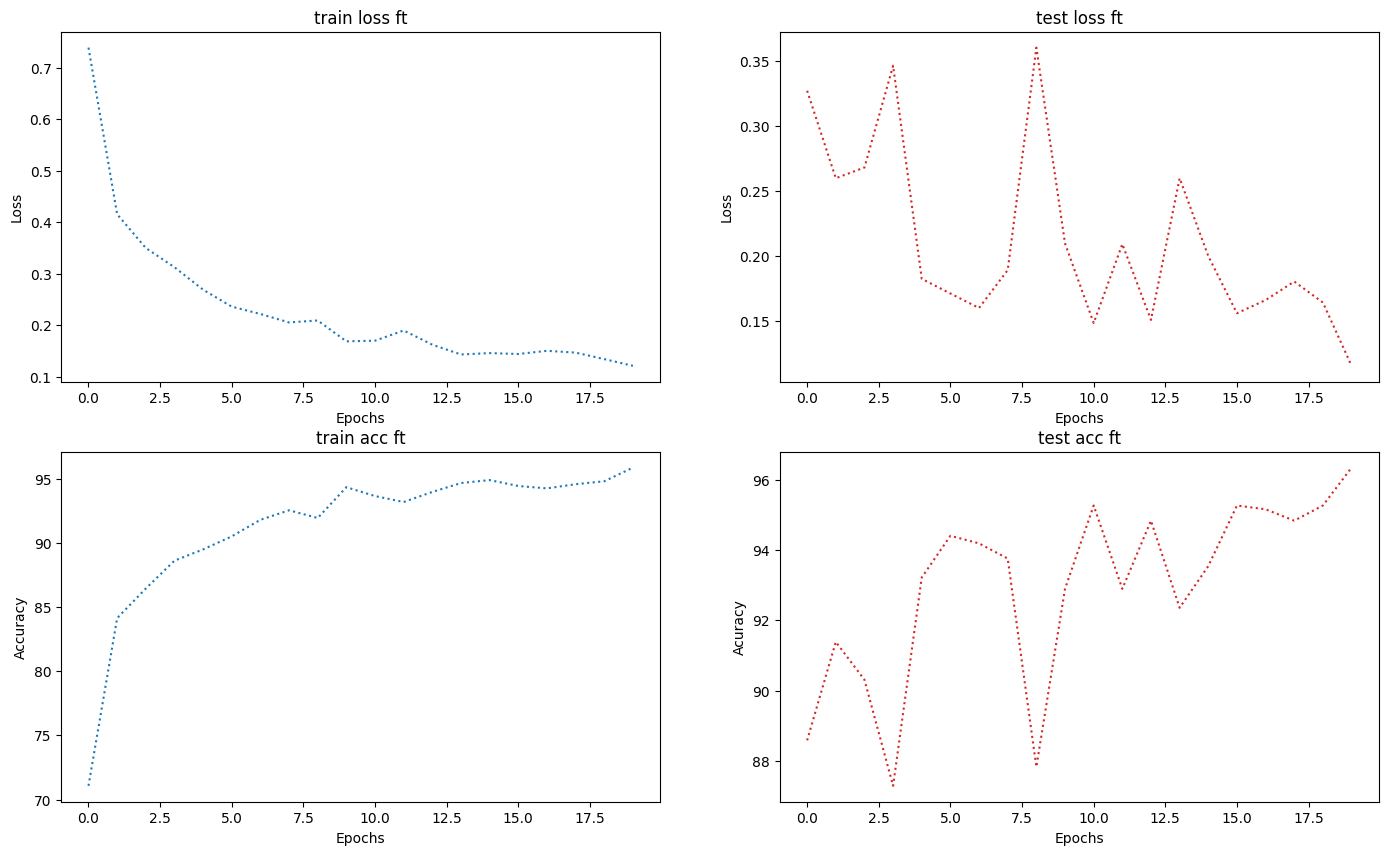

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(17, 10))

axs[0,0].plot(train_loss_ft, color='tab:blue', linestyle='dotted')
axs[0,0].set_xlabel('Epochs')
axs[0,0].set_ylabel('Loss')
axs[0,0].set_title('train loss ft')

axs[0,1].plot(valid_loss_ft, color='tab:red', linestyle='dotted')
axs[0,1].set_xlabel('Epochs')
axs[0,1].set_ylabel('Loss')
axs[0,1].set_title('test loss ft')

axs[1,0].plot(train_acc_ft, color='tab:blue', linestyle='dotted')
axs[1,0].set_xlabel('Epochs')
axs[1,0].set_ylabel('Accuracy')
axs[1,0].set_title('train acc ft')

axs[1,1].plot(valid_acc_ft, color='tab:red', linestyle='dotted')
axs[1,1].set_xlabel('Epochs')
axs[1,1].set_ylabel('Acuracy')
axs[1,1].set_title('test acc ft')

# Visualize performance of training resnet model from scratch vs fine tuning

> Prediction on test data for both models

In [23]:
with torch.no_grad():
    label_pred = []
    label_true = []
    label_pred_ft = []
    for images, labels in test_loader:

        images = images.to(device)
        labels = labels.to(device)
        y_pred = model(images)
        y_pred_ft = model_ft(images)
        _, preds = torch.max(y_pred.data, 1)
        _, preds_ft = torch.max(y_pred_ft.data, 1)
        
        # moves the tensors back to the CPU. and extend to a list 
        label_pred.extend(preds.cpu())         
        label_true.extend(labels.cpu())
        label_pred_ft.extend(preds_ft.cpu())         


In [24]:
#give item for each tensor in a list of tensors and then convert to a array
label_pred = np.array([tensor.item() for tensor in label_pred])
label_true = np.array([tensor.item() for tensor in label_true])
label_pred_ft = np.array([tensor.item() for tensor in label_pred_ft])


> f1_score, recall_score, precision_score, confusion_matrix

training resnet from scratch 


F1-Score:[0.7604234101867768]
Precision:[0.7961505931568813]
Recall:[0.8040823178050545]
-----------------------
FineTuning Resnet 


F1-Score:[0.9667334658583303]
Precision:[0.9661380026832078]
Recall:[0.9676817942903417]
Classification_Report
-----------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       224
           1       0.81      0.81      0.81       278
           2       0.53      0.98      0.69       143
           3       1.00      0.48      0.65       284

    accuracy                           0.77       929
   macro avg       0.80      0.80      0.76       929
weighted avg       0.83      0.77      0.76       929

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       256
           1       0.96      0.94      0.95       286
           2       0.94      0.98      0.96       251
           3       0.99      0.99      0.99    

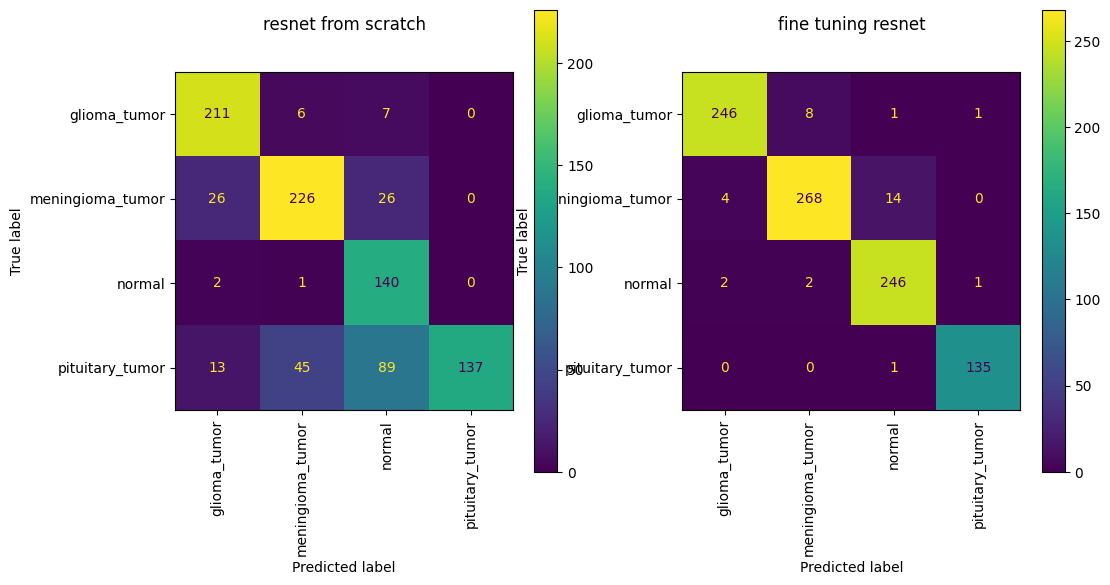

In [25]:
f1_scores=[]
precision_scores=[]
recall_scores=[]

f1_scores_ft=[]
precision_scores_ft=[]
recall_scores_ft=[]

f1_scores.append(f1_score(label_pred, label_true, average="macro"))
precision_scores.append(precision_score(label_pred, label_true, average="macro"))
recall_scores.append(recall_score(label_pred, label_true, average="macro"))

f1_scores_ft.append(f1_score(label_pred_ft, label_true, average="macro"))
precision_scores_ft.append(precision_score(label_pred_ft, label_true, average="macro"))
recall_scores_ft.append(recall_score(label_pred_ft, label_true, average="macro"))


# Print the Results
print("training resnet from scratch","\n\n")
print(f"F1-Score:{f1_scores}")
print(f"Precision:{precision_scores}")
print(f"Recall:{recall_scores}")
print("-----------------------")

print("FineTuning Resnet","\n\n")
print(f"F1-Score:{f1_scores_ft}")
print(f"Precision:{precision_scores_ft}")
print(f"Recall:{recall_scores_ft}")



print("Classification_Report")
print("-----------------------")
print(classification_report(label_pred, label_true))
print(classification_report(label_pred_ft, label_true))
print("Confusion_Matrix")
print("----------------------")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
cmd = ConfusionMatrixDisplay.from_predictions(label_pred, label_true, display_labels=labels_name, xticks_rotation="vertical",ax=ax1)
cmd_ft = ConfusionMatrixDisplay.from_predictions(label_pred_ft, label_true, display_labels=labels_name, xticks_rotation="vertical",ax=ax2)

cmd.ax_.set_title("resnet from scratch",pad=30)
cmd_ft.ax_.set_title("fine tuning resnet", pad=30)

plt.show()
